
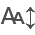

In [1]:
import pandas as pd
from itables import init_notebook_mode 
from dotenv import load_dotenv 
import boto3 
import os 
from pycaret.classification import setup, compare_models, pull
import matplotlib.pyplot as plt
import seaborn as sns
from itables import options as itbl_options # itables: zezwól na renderowanie HTML (np. dla pandas Styler)
itbl_options.allow_html = True
from pycaret.regression import setup as reg_setup, compare_models as reg_compare_models, tune_model as reg_tune_model, finalize_model as reg_finalize_model, predict_model as reg_predict_model, pull as reg_pull, save_model as reg_save_model, load_model as reg_load_model, get_metrics as reg_get_metrics, add_metric as reg_add_metric

init_notebook_mode(all_interactive=True)

load_dotenv()
BUCKET_NAME = "zadaniedomowe9"

In [2]:
s3 = boto3.client("s3")
response = s3.list_objects_v2(Bucket=BUCKET_NAME)

for obj in response["Contents"]:
    print(obj["Key"]) 

halfmarathon_wroclaw_2023__final.csv
halfmarathon_wroclaw_2024__final.csv
model/app_zad_dom_9_regressor.pkl


In [3]:
wr23_df = pd.read_csv(f"s3://{BUCKET_NAME}/halfmarathon_wroclaw_2023__final.csv", sep=';')
wr24_df = pd.read_csv(f"s3://{BUCKET_NAME}/halfmarathon_wroclaw_2024__final.csv", sep=';')


In [4]:
wr23_df["Rok"] = 2023
wr24_df["Rok"] = 2024

In [5]:
merge_df = pd.concat([wr23_df, wr24_df], ignore_index=True)
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21957 entries, 0 to 21956
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Miejsce                    18450 non-null  float64
 1   Numer startowy             21957 non-null  int64  
 2   Imię                       21957 non-null  object 
 3   Nazwisko                   21957 non-null  object 
 4   Miasto                     17774 non-null  object 
 5   Kraj                       18450 non-null  object 
 6   Drużyna                    8402 non-null   object 
 7   Płeć                       21946 non-null  object 
 8   Płeć Miejsce               18450 non-null  float64
 9   Kategoria wiekowa          21926 non-null  object 
 10  Kategoria wiekowa Miejsce  18430 non-null  float64
 11  Rocznik                    21472 non-null  float64
 12  5 km Czas                  18411 non-null  object 
 13  5 km Miejsce Open          18411 non-null  flo

In [6]:
merge_df

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [7]:
#  Usuwanie brakujących wartości
merge_df.dropna(subset=['Płeć', 'Rocznik', '5 km Czas',
                        '10 km Czas', '15 km Czas', '20 km Czas',
                         'Czas', 'Rok'], inplace=True) # usuwamy wiersze z brakującymi wartościami

In [8]:
def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF', ""]:
        return None
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])

merge_df['Czas'] = merge_df['Czas'].apply(convert_time_to_seconds)
merge_df['20 km Czas'] = merge_df['20 km Czas'].apply(convert_time_to_seconds)
merge_df['10 km Czas'] = merge_df['10 km Czas'].apply(convert_time_to_seconds)
merge_df['15 km Czas'] = merge_df['15 km Czas'].apply(convert_time_to_seconds)
merge_df['5 km Czas'] = merge_df['5 km Czas'].apply(convert_time_to_seconds)
# merge_df.head()

In [9]:
# Obliczamy średni czas na 5 km
# dodajemy czasy z '20 km Czas'+ '15 km Czas'+ '10 km Czas'+ '5 km Czas' i dzielimy na 10
merge_df['Średni Czas na 5 km'] = (
    merge_df['20 km Czas'] +
    merge_df['15 km Czas'] +
    merge_df['10 km Czas'] +
    merge_df['5 km Czas']
) / 10

In [10]:
merge_df = merge_df[['Płeć', 'Rocznik', 'Średni Czas na 5 km', 'Czas','Rok']]
merge_df.drop(merge_df[merge_df['Rocznik'] < 1].index, inplace=True) # usuń wiersz jeśli rocznik = 0
merge_df 

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


<Axes: xlabel='Rocznik', ylabel='Średni Czas na 5 km'>

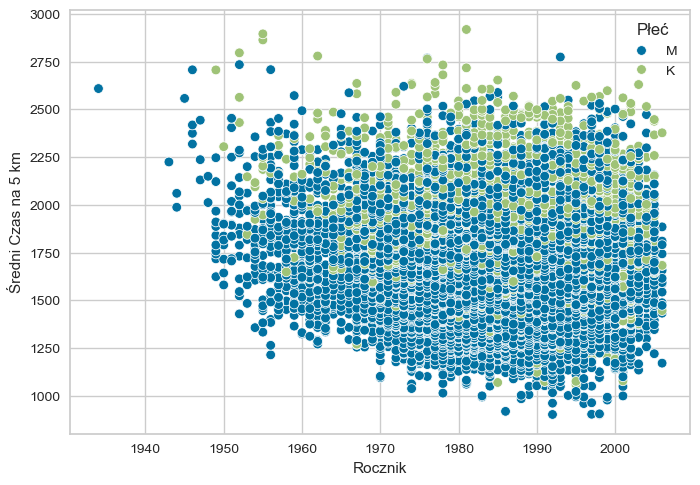

In [11]:
fig, axes = plt.subplots()

sns.scatterplot(data=merge_df, x='Rocznik', y=('Średni Czas na 5 km'), hue='Płeć', ax=axes)

In [12]:
# Balansowanie danych do trenowania

from typing import Tuple
import numpy as np
from sklearn.model_selection import train_test_split

def make_strata(merge_df: pd.DataFrame) -> pd.Series:
    """Tworzy klucz straty łącząc rok i płeć ('Płeć' z wartościami 'M'/'K')."""
    return merge_df['Rok'].astype(str) + '_' + merge_df['Płeć'].astype(str)

def downsample_to_min(merge_df: pd.DataFrame, strata_col: str) -> pd.DataFrame:
    """Downsampling: przycina każdą klasę straty do minimalnej liczności."""
    groups = merge_df.groupby(strata_col)
    min_n = groups.size().min()
    parts = [g.sample(min_n, random_state=42) for _, g in groups]
    return pd.concat(parts, ignore_index=True)

def upsample_to_max(merge_df: pd.DataFrame, strata_col: str) -> pd.DataFrame:
    """Upsampling: dociąga każdą klasę straty do maksymalnej liczności z losowaniem z powtórzeniami."""
    groups = merge_df.groupby(strata_col)
    max_n = groups.size().max()
    parts = [g.sample(max_n, replace=True, random_state=42) for _, g in groups]
    return pd.concat(parts, ignore_index=True)

# Konfiguracja
feature_cols = [
    'Rocznik', 'Rok', 'Płeć', 'Średni Czas na 5 km'
]
# Target: całkowity czas półmaratonu w sekundach
target_col = 'Czas'

In [13]:
# 1) Sprawdź rozkład przed podziałem
merge_df['strata'] = make_strata(merge_df)
print('Rozkład całego zbioru (strata):', merge_df['strata'].value_counts().to_dict())

# 2) Podział train/test z utrzymaniem proporcji w stracie
train_df, test_df = train_test_split(
    merge_df,
    test_size=0.2,
    random_state=42,
    stratify=merge_df['strata']
)
print('\nRozkład TRAIN przed balansowaniem:', train_df['strata'].value_counts().to_dict())
print('Rozkład TEST:', test_df['strata'].value_counts().to_dict())

# 3) Balansowanie zbioru treningowego (downsampling do najmniejszej klasy)
train_bal = downsample_to_min(train_df, 'strata')
print('\nRozkład TRAIN po balansowaniu:', train_bal['strata'].value_counts().to_dict())

# 4) Kodowanie płci do modelowania (LabelEncoder: M=1, K=0)
from sklearn.preprocessing import LabelEncoder
le_sex = LabelEncoder()
for df_ in (train_bal, test_df):
    df_['Płeć_LE'] = le_sex.fit_transform(df_['Płeć']) if 'Płeć_LE' not in df_.columns else df_['Płeć_LE']

# 5) Zbuduj macierze cech i wektor celu (zastępujemy Płeć -> Płeć_LE)
feature_cols_encoded = [c if c != 'Płeć' else 'Płeć_LE' for c in feature_cols]
X_train_bal = train_bal[feature_cols_encoded].copy()
y_train_bal = train_bal[target_col].copy()
X_test = test_df[feature_cols_encoded].copy()
y_test = test_df[target_col].copy()

print('\nUżyte cechy:', feature_cols_encoded)
print('Kształty:', 'X_train_bal', X_train_bal.shape, 'y_train_bal', y_train_bal.shape, 'X_test', X_test.shape, 'y_test', y_test.shape)

train_bal.head()

Rozkład całego zbioru (strata): {'2024_M': 7050, '2023_M': 5674, '2024_K': 2926, '2023_K': 2228}

Rozkład TRAIN przed balansowaniem: {'2024_M': 5640, '2023_M': 4539, '2024_K': 2341, '2023_K': 1782}
Rozkład TEST: {'2024_M': 1410, '2023_M': 1135, '2024_K': 585, '2023_K': 446}

Rozkład TRAIN po balansowaniu: {'2023_K': 1782, '2023_M': 1782, '2024_K': 1782, '2024_M': 1782}

Użyte cechy: ['Rocznik', 'Rok', 'Płeć_LE', 'Średni Czas na 5 km']
Kształty: X_train_bal (7128, 4) y_train_bal (7128,) X_test (3576, 4) y_test (3576,)


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


<Axes: xlabel='Rok', ylabel='Czas'>

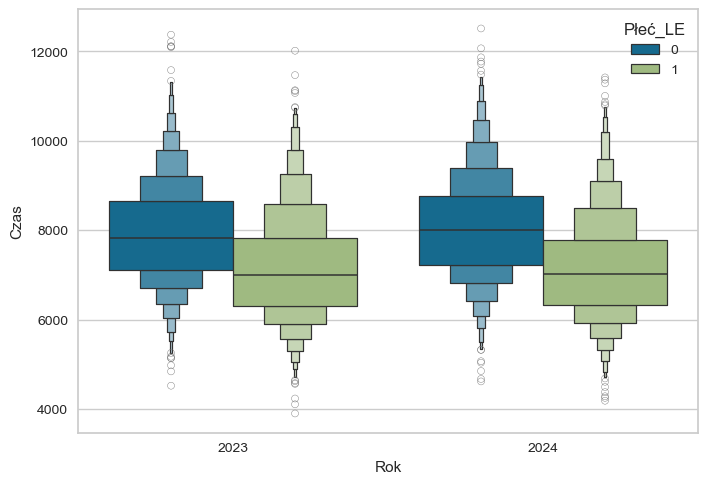

In [14]:
fig, axes = plt.subplots()

sns.boxenplot(data=train_bal, x='Rok', y='Czas', hue='Płeć_LE', ax=axes)

<Axes: >

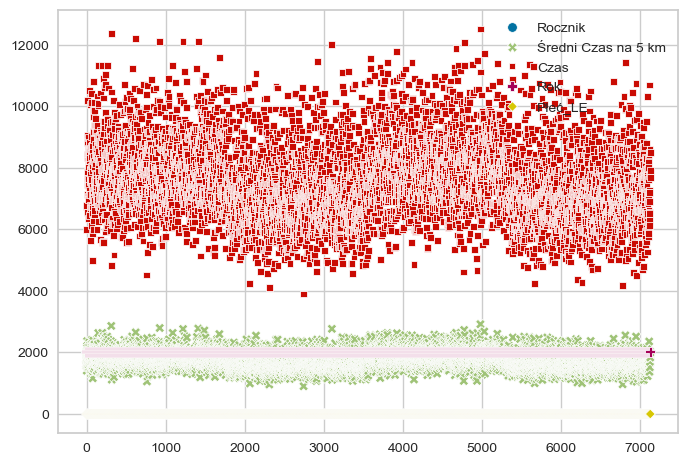

In [15]:
fig, axes = plt.subplots()

sns.scatterplot(data=train_bal, ax=axes)

In [16]:
Q1 = train_bal["Czas"].quantile(0.25)
Q3 = train_bal["Czas"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
train_bal = train_bal[~((train_bal["Czas"] < lower_bound) | (train_bal["Czas"] > upper_bound))]

<Axes: xlabel='Rok', ylabel='Czas'>

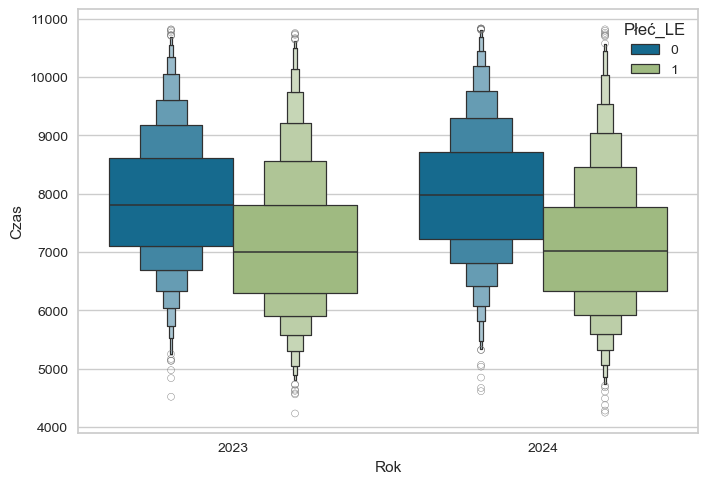

In [17]:
fig, axes = plt.subplots()

sns.boxenplot( data=train_bal, x='Rok', y='Czas', hue='Płeć_LE', ax=axes)

<Axes: >

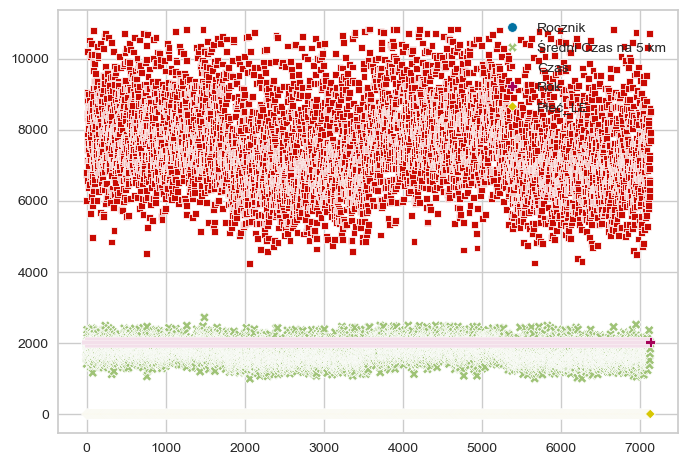

In [18]:
fig, axes = plt.subplots()

sns.scatterplot(data=train_bal, ax=axes)

In [19]:
# Standaryzacja cech numerycznych (bez targetu)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_bal[feature_cols_encoded] = scaler.fit_transform(X_train_bal[feature_cols_encoded])
X_test[feature_cols_encoded] = scaler.transform(X_test[feature_cols_encoded])

In [20]:
train_bal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7065 entries, 0 to 7127
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Płeć                 7065 non-null   object 
 1   Rocznik              7065 non-null   float64
 2   Średni Czas na 5 km  7065 non-null   float64
 3   Czas                 7065 non-null   int64  
 4   Rok                  7065 non-null   int64  
 5   strata               7065 non-null   object 
 6   Płeć_LE              7065 non-null   int32  
dtypes: float64(2), int32(1), int64(2), object(2)
memory usage: 414.0+ KB


<Axes: xlabel='Rocznik', ylabel='Średni Czas na 5 km'>

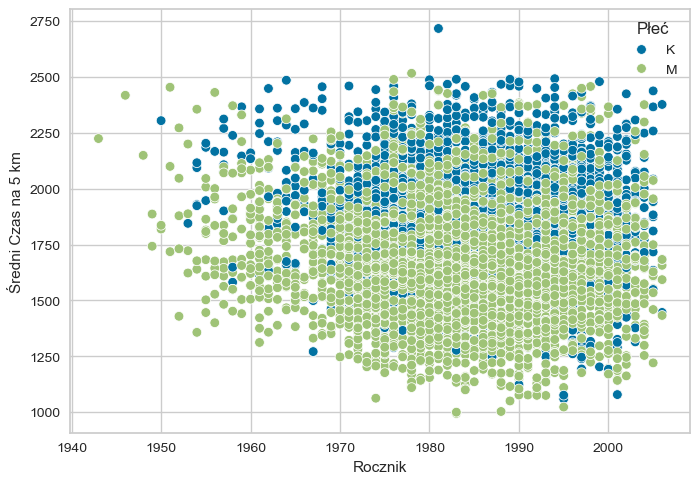

In [21]:
fig, axes = plt.subplots()

sns.scatterplot(data=train_bal, x='Rocznik', y=('Średni Czas na 5 km'), hue='Płeć', ax=axes)

In [22]:
# Predykcja czasu półmaratonu z 5 km, płci i rocznika

# Cechy dla aplikacji
app_features = ['Średni Czas na 5 km', 'Rocznik', 'Płeć_LE']

# Przygotuj dane wejściowe do modelu półmaratonu z ograniczonymi cechami
if 'Płeć_LE' not in train_bal.columns:
    le_tmp = LabelEncoder()
    train_bal['Płeć_LE'] = le_tmp.fit_transform(train_bal['Płeć'])

train_app = train_bal[app_features + [target_col]].copy()

# PyCaret setup tylko na tych cechach
reg_exp_app = reg_setup(
    data=train_app,
    target=target_col,
    session_id=42,
    normalize=True,
    verbose=False,
    fold=5
)

best_model_app = reg_compare_models()
final_model_app = reg_finalize_model(best_model_app)

# Zapisz osobny model do aplikacji (przewiduje półmaraton z 5k/rocznik/płeć)
os.makedirs('model', exist_ok=True)
reg_save_model(final_model_app, 'model/app_zad_dom_9_regressor')

final_model_app

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


Transformation Pipeline and Model Successfully Saved


Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['Średni Czas na 5 km', 'Rocznik',
                                             'Płeć_LE'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('clean_column_names',
                 TransformerWrapper(transformer=CleanColumnNames())),
                ('actual_estimator',
                 GradientBoostingRegressor(random_state=42))])

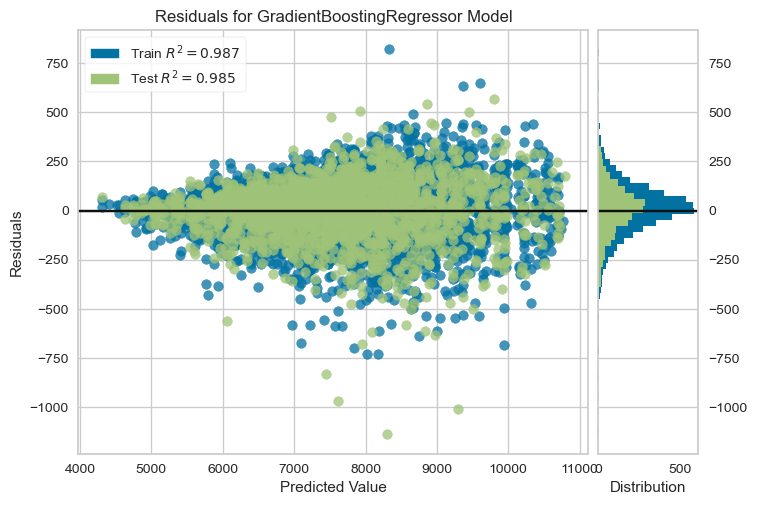

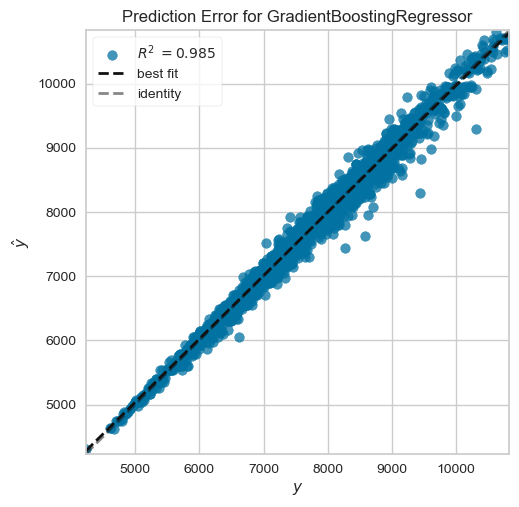

In [23]:
# Wykresy odpowiednie dla regresji
reg_exp_app.plot_model(final_model_app, plot="residuals")
reg_exp_app.plot_model(final_model_app, plot="error")


In [24]:
# Funkcje dla apki
# transformacja czasu

def seconds_to_hms_str(seconds: float) -> str:
    seconds = int(round(seconds))
    h = seconds // 3600
    m = (seconds % 3600) // 60
    s = seconds % 60
    return f"{h:02d}:{m:02d}:{s:02d}"

# Zwraca przewidywany czas PÓŁMARATONU na podstawie rocznika, płci (M/K) i czasu 5k HH:MM:SS.
def app_infer_halfmarathon_time(model, rocznik: int, plec: str, czas_5k_hms: str) -> dict:
    # parse 5k
    h, m, s = map(int, czas_5k_hms.split(':'))
    t5 = h * 3600 + m * 60 + s

    # zakoduj płeć do Płeć_LE zgodnie z LabelEncoder: K->0, M->1 (przy standardowym alfabecie)
    plec_norm = 'M' if plec.upper().startswith('M') else 'K'
    plec_le = 1 if plec_norm == 'M' else 0

    # przygotuj ramkę wejściową
    X = pd.DataFrame([
        {'Średni Czas na 5 km': t5, 'Rocznik': int(rocznik), 'Płeć_LE': plec_le}
    ])

    # przewidź półmaraton
    pred_half = reg_predict_model(model, data=X)['prediction_label'].iloc[0]

    return {
        'wejscie': {'rocznik': rocznik, 'plec': plec_norm, 'czas_5k': czas_5k_hms},
        'pred_half_seconds': float(pred_half),
        'pred_half_hms': seconds_to_hms_str(pred_half),
    }

In [25]:
# Test
example = app_infer_halfmarathon_time(
    model=final_model_app,
    rocznik=1975,
    plec='M',
    czas_5k_hms='00:15:00',
)
example

{'wejscie': {'rocznik': 1975, 'plec': 'M', 'czas_5k': '00:15:00'},
 'pred_half_seconds': 4302.349918099814,
 'pred_half_hms': '01:11:42'}

In [ ]:
# upload
local_pkl = 'app_zad_dom_9_regressor.pkl'
s3_path = "model/app_zad_dom_9_regressor.pkl"

s3.upload_file(
    Filename=local_pkl,
    Bucket=BUCKET_NAME,
    Key=s3_path
)
print(f'Wysłano do s3://{BUCKET_NAME}/{s3_path}')